We first install the new library using pip. We also install nbdev

In [0]:
! pip -q install 'git+https://github.com/fastai/fastai2.git'

  Cloning https://github.com/fastai/fastai2.git to /tmp/pip-req-build-c4ocobed
  Running command git clone -q https://github.com/fastai/fastai2.git /tmp/pip-req-build-c4ocobed
  Created wheel for fastai2: filename=fastai2-0.0.16-cp36-none-any.whl size=183739 sha256=b3b9f04c4c3e4eabc07f77485003946e413ca74b9b1802221ba43b5364048b82
  Stored in directory: /tmp/pip-ephem-wheel-cache-9eqctyqy/wheels/38/fd/31/ec7df01a47c0c9fafe85a1af76b59a86caf47ec649710affa8
Successfully built fastai2


In [0]:
! pip install nbdev

     |████████████████████████████████| 51kB 913kB/s 


Import the awesome library

In [0]:
from fastai2.vision.all import *
from nbdev import *

Yay! we can now start doing some good stuff

In [0]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

As you can see lots of new functionalities have been added. Jeremy and Sylvian figured out how to supercharge python for their needs. The list shown above is a special `L` list object in fastai2. As you can ssee simply calling it shows the size of the list and as usual all the items in that list.

We can use the fastai method `get_image_files` to check all the images in the `path/'images` path and remove the ones that aren't image files. In our case, files with a `.mat`.

In [0]:
len((path/'images').ls())

7393

In [0]:
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_54.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_181.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_44.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_145.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_159.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_177.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_85.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_69.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_200.jpg')...]

In [0]:
files = get_image_files(path/'images')
files[10:200], len(files)

((#190) [Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_57.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_69.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_84.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_73.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_14.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_118.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_174.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_75.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_110.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_112.jpg')...],
 7390)

To see the files that were removed

In [0]:
for i in (path/'images').ls():
  if i not in files:
    print(i)

/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat
/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.mat
/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.mat


Our task is to build a simple Cats vs Dogs classifier using the highlevel API and the medium level API. I'll try as much as possible to annotate as much as i can

We start off with the high level API. We'll be making use the ImageDataLoaders class which has a custom method for labelling called `from_name_func`. This is used beacase in the dataset we loaded above, the files are saved in a format called the *imagenet directory format* where the names of the files show the type of content(label) in that file. In our case, all the pictures of cats start with uppercase so we write a simple helper func to help us seperate the files into cats and dog files

In [0]:
files[0].name, files[103].name  #dog, cat

('yorkshire_terrier_78.jpg', 'Sphynx_206.jpg')

In [0]:
def file_splitter(x):
  return x[0].isupper()  #returns a boolean

In [0]:
dls = ImageDataLoaders.from_name_func(path=path, fnames=files, label_func=file_splitter, valid_pct=0.2,
                                      item_tfms=Resize(200))

One thing unique to note here is the transforms. We are using an item transfromation. In this new API, they are 2 types of transforms that can be applied on the dataset, they are Itema dn batch transforms. Item transfroms are applied on eahc of the items on the CPU before they are then batched up and sent into the GPU by the pytorch dataloader. The batch transforms however are applied on the batched input which are in the gpu. The batch transforms are applied individually to each of the batched in the pytorch dataloader

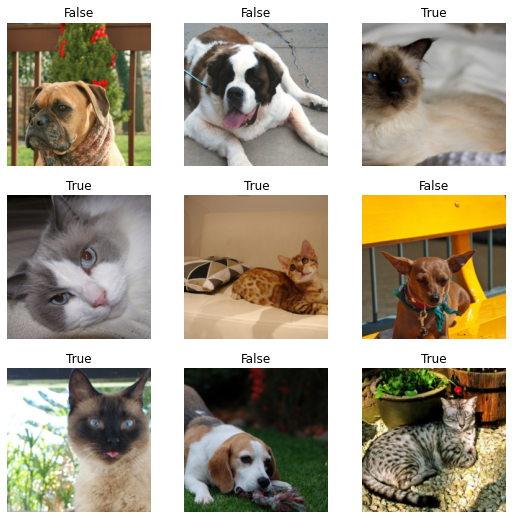

In [0]:
dls.show_batch()

Evrything works!!

We can now create a Fastai learner that we will train on the data

Keep in mind that the `arch` is just the function that we will use to model our data to find it's best params by evealuating on the valid set. The metrics are just the things that get printed out while training

In [0]:
learn = cnn_learner(dls, arch=resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


We are making use of a learning technique called *tranfer learning* which basically us using the learned parameters of a resnet34 model trained on imagenet which contains 1M+ images to train on our own custom dataset(in this case cats vs dogs). The idea is to not use a model that knows nothing about anything but instead to use a model that knows a little about somethings as a backbone to train our own custom data. This training on our own custom data using pretrainined weights is called *fine-tuning*. Let us fine-tune!!

In [0]:
learn.fine_tune(epochs=1)

NB: The trick behind finetuning is to freeze the backbone of the model and unfreeze the head with randomly initialized params while training for a single epoch. Then unfreeze the params of the backbone and the head and train for as many epochs as specified to adjust the params of the head further

After a single epoch we have a model that can classify between cats and dogs with an accuracy of 99.39%. This took ~2 mins. Amazing right?

Let's see how our model perfroms

(500, 400)


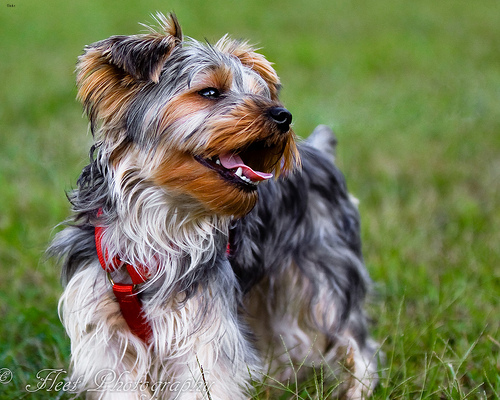

In [0]:
print(PILImage.create(files[0]).size)
PILImage.create(files[0])

(192, 154)


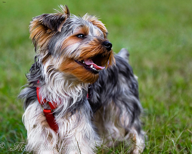

In [0]:
img = PILImage.create(files[0])
print((img.to_thumb(192)).size)  #to_thumb is used to resize an Image object while maintaing aspect ratio
(img.to_thumb(192))

To list the classes in the dataloader, use the `decode` method

In [0]:
dls.vocab

(#2) [False,True]

In [0]:
learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 6.9719e-08]))

This gives the class of the prediction, the id of the tensor in the vocab list and the models probability for each of the labels

In [0]:
def is_it_a_cat(item: Path):
  res = learn.predict(item)
  return (f'{res[0]} with a probability of catiness: {res[2][1]*100:.4f}%')

In [0]:
is_it_a_cat(files[0])

'False with a probability of catiness: 0.0000%'

Yay!!

One of the reasons to love fastai is that there are lots of ways to do most things. This new library is especially special. We can use a SimpleNameSpace to create a customizable function where we can pass any argument we want and access those arguments simply by calling them. The power of OOP is fully leveraged here

In [0]:
SimpleNamespace(anyname_i_want='whatever i want can be here')

namespace(anyname_i_want='whatever i want can be here')

In [0]:
# download a random image of a cat
! wget 'https://cdn.mos.cms.futurecdn.net/7cS2DrDAMFRQSMpMyfFDvW.jpg' -O cat.jpeg

--2020-03-27 13:37:14--  https://cdn.mos.cms.futurecdn.net/7cS2DrDAMFRQSMpMyfFDvW.jpg
Resolving cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)... 67.27.151.252, 8.247.209.252, 67.26.105.252
Connecting to cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)|67.27.151.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181956 (178K) [image/jpeg]
Saving to: ‘cat.jpeg’

cat.jpeg            100%[===================>] 177.69K  --.-KB/s    in 0.01s   

2020-03-27 13:37:14 (16.1 MB/s) - ‘cat.jpeg’ saved [181956/181956]



In [0]:
upload = SimpleNamespace(img='cat.jpeg')

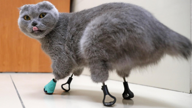

In [0]:
PILImage.create(upload.img).to_thumb(192)

In [0]:
is_it_a_cat(upload.img)

'True with a probability of catiness: 99.9951%'

## Top It Up A Notch

We've seen how to classify dogs vs cats from image. Let's make the problem a bit more complex. Let's classify cat and dog breeds from each other with a neural net

Using the high level API

As we can see, the names of the breed of each animal is the name of the image file plus a random number which we don't need. We can use a regex to extract this name(which is our label) from the file path of every image

In [0]:
files[:5]

(#5) [Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_36.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_159.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_5.jpg')]

In [0]:
pat = r'([^/]+)_\d+.jpg$'

We will use a regex labeller this time to get the labels. Thankfully fastai has a custom `from_name_re` method in `ImageDataLoaders` to help us with this

This time we'll be using `item_tfms` and `batch_tfms`. What it tels us is that for each item in the Imageitemslist, resize it to 224. This should be done on the CPU(in pytorch Dataset class). Then use a pytorch dataloader class to group the items into batches and  load up each batch into the GPU. Then apply some default fatsai transform in aug_transforms to every batch that is selected for training. We are specifying the `size` `aug_transform` done on every batch to resize the images in that batch to 224 and then apply the other default tranforms.

NB: It is important to note that augmentations don't increase the number of images in the training set. What it does is that for evey batch selected, it performs transforms on the fly and return that batch the way it was

In [0]:
dls = ImageDataLoaders.from_name_re(path, files, pat=pat, item_tfms=Resize(448),
                                    batch_tfms=aug_transforms(size=224))

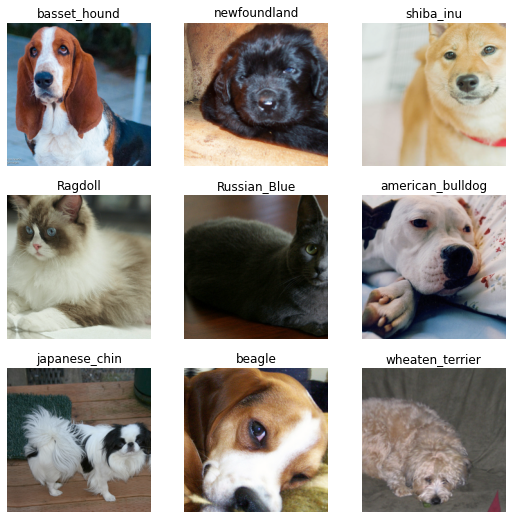

In [0]:
dls.show_batch()

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Let's find the best learning rate. We dont have to call `recorder` any more like before Yipee!!!


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.005248074419796467)

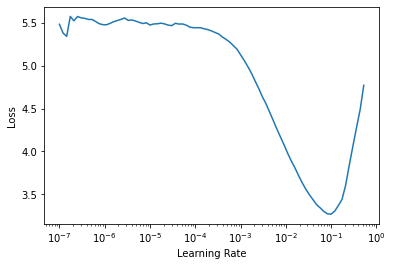

In [0]:
learn.lr_find()

lr_find gives us the lowest point in the curve and also the suggested learning rate to use. How cool is that

In [0]:
learn.fine_tune(4, 5e-3)

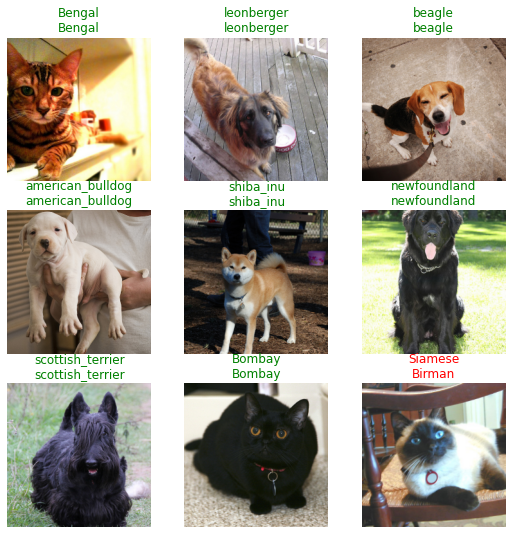

In [0]:
learn.show_results()

We can see the classes/categories that the model got wrong by creating a ClassifcationInterpretation

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.top_losses()

torch.return_types.topk(values=tensor([11.7377, 11.7364,  9.0359,  ..., -0.0000, -0.0000, -0.0000]), indices=tensor([ 176,  227, 1368,  ...,  995,  972,  609]))

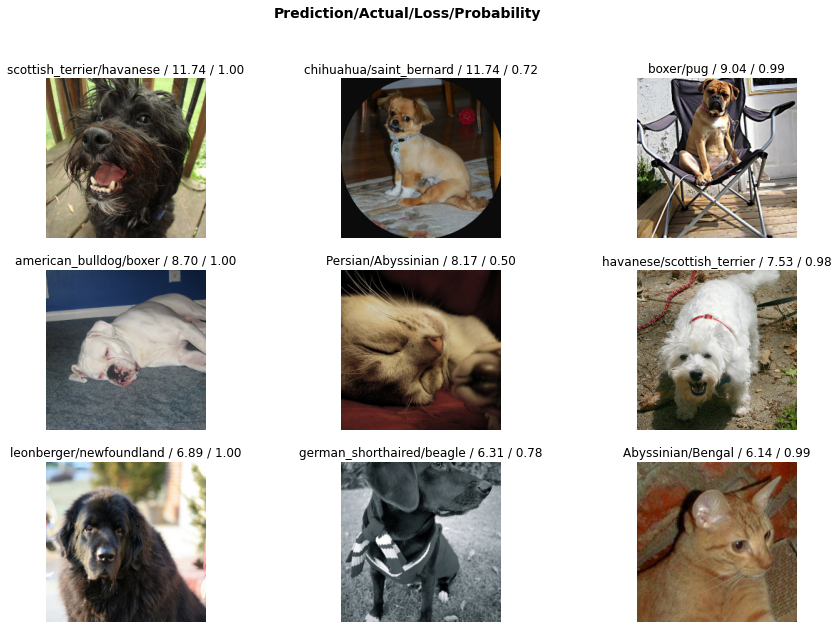

In [0]:
interp.plot_top_losses(9, figsize=(15, 10))

In [0]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Bengal', 'Abyssinian', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Birman', 'Siamese', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('boxer', 'american_bulldog', 2),
 ('boxer', 'american_pit_bull_terrier', 2),
 ('english_setter', 'chihuahua', 2),
 ('havanese', 'scottish_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('pug', 'staffordshire_bull_terrier', 2)]

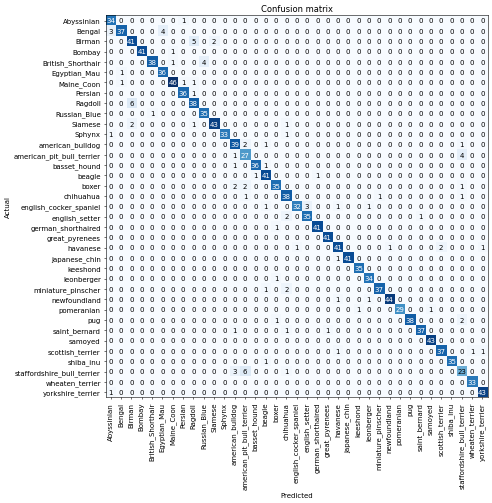

In [0]:
interp.plot_confusion_matrix(figsize=(15, 10), dpi=50)

In [0]:
files[100].name

'British_Shorthair_27.jpg'

In [0]:
upload = SimpleNamespace(img=files[100])

In [0]:
learn.predict(upload.img)[0]

'British_Shorthair'

**FIN**

## Time to put on our big-boy pants

We'll be delving head first into the mid-level API. Fasten your seatbelts and enjoy the ride!

### The DATABLOCK

What is a DataBlock: It is baically an abstraction that takes in pytorch train, valid and test Dataloader objects and bunches then up together so we can performs operations on them easily.

NB: It's important to note that DataBlocks can only be used in training when a pytorch DataLoader object has been created in it. This created dataloader will live in fastai's `dataloaders` method of the datablock. The way to create a dataloader in a Datablock is by getting the X, performing a valid split, getting the y and then applying transforms. 

It is also important to know that is the dataloader has not been properly created in the DAtaBlock, we will not have access to the dataloaders method of the Datablock but only the access to the datasets attribute which contains a pytorch dataset

I'm sure this is a hand wavy explanation so I'll use code to make it clearer

Instantiate a DataBlock (Note that this only creates a data set and not a dataloader)

In [0]:
data = DataBlock()

It is also important to note that the DataBlock is just an architectural abstractive representation of how the training and valid data will be structured. We now have to pass in a data source into either the datasets or the dataloaders method of the DataBlock after instantiating it

accessing the dataloaders property of a DataBlock without a pytorch dataloader should throw and error

In [0]:
data.dataloaders(get_image_files(path/'images'))

Could not do one pass in your dataloader, there is something wrong in it


But we can easily access the datasets method of the DataBlock which is a pytorch dataset

In [0]:
dset = data.datasets(get_image_files(path/'images'))

Remember that a datset is something you can index into and also get it's lenght

In [0]:
dset.train, dset.valid

((#5912) [(Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_153.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_153.jpg')),(Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_109.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_109.jpg')),(Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_190.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_190.jpg')),(Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_14.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_14.jpg')),(Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_116.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_116.jpg')),(Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_174.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_174.jpg')),(Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_147.jpg'), Path('/root/.fastai/data/oxford-

In [0]:
dset.train[0], len(dset.train)

((Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_153.jpg'),
  Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_153.jpg')),
 5912)

we have a tuple as a result of the slice because by default the output from a dataset by default is supposed to be (input, target) and since we haven't specified our target (cus we haven't created a complete DataBlock) it sets the target as the input in the tuple 

Every fastai datablock must tick the following boxes;
- Types of blocks beings used. The first block in the tuple represents the independent data type and the second represents the dependent data-type for the problem being solved
- The getters: They literally get stuff in our case, Images and labels from the `L` list ItemList. There's one for the x and another for the y.
 - How to get the desired x(image files) from the ItemList. In our case we have an ItemList with a mixture of image files and `.mat files` so we remove the `.mat` files by passing in get_image_items to the get_item argument.
 - How to get the y (label). We use the `get_y` argument for this to extract the labels from the x above. `x.name` will be called on each x
- How to split the items in the ItemList into train and valid set. This actually occurs inbetween the getters
- The transforms to apply to the items and to the batches ie `item_tfms` and `batch_tfms`

It's as easy as it looks, trust me!

In [0]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 #using_attr takes the second argument as an attribute for x and 
                #  passes it as an argument into the first argument of using_attr
                 get_y=using_attr(RegexLabeller(pat), 'name'),
                 item_tfms = Resize(448),
                 batch_tfms = aug_transforms(size=224))

**OR another way to do this is** 

I find this way to be more intuitive

In [0]:
data = DataBlock(blocks = (ImageBlock, CategoryBlock),
                #  this time we use a get_x instead of a get_item
                 get_x = lambda o: o,
                 splitter = RandomSplitter(valid_pct=0.2, seed=42),
                 get_y = using_attr(RegexLabeller(pat), 'name'),
                 item_tfms = Resize(448),
                 batch_tfms=aug_transforms(size=224))

The good thing is that we have made our DataBlock but the bad news is that it is totally useless for now. In order to make it useful, we need to make it a DataLoaders object while specifying the path our dataset resides. Think of it this way, the datablock which we have just crwated is the architecutre/functional representsation. This arch needs to be passed in some data to be able to work

**CONFUSION**: Itried setting normalize to use imagenet_stats but when i created the dataloader, I got an error

In [0]:
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [0]:
# dls = data.dataloaders(path/'images')

# if using second method
dls = data.dataloaders(files)

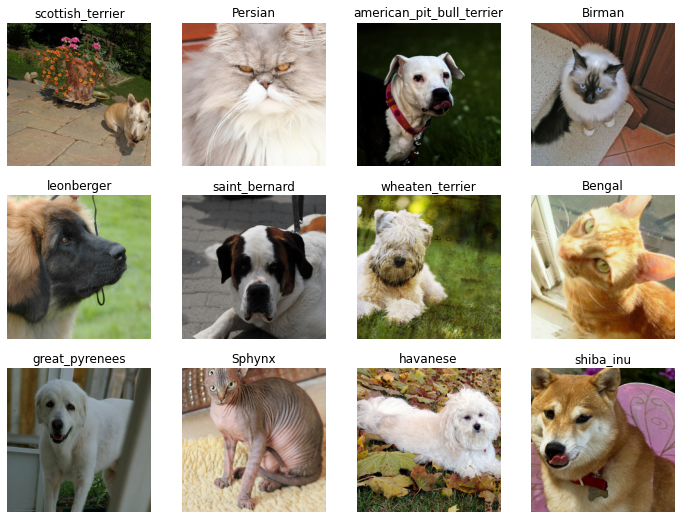

In [0]:
dls.show_batch(max_n=12) #maximum number to display

Training is exactly the same process as done earlier

##Unto another task!!!

This time we will be looking at MultiLabel classification. What we did above was a multiclass classification problem where there were lots of classes and every image fell into one of those classes ie only one class describes every image. This time, there are lots of images and each image has one or more classes/labels describing it

The dataset we will use for this is the pascal dataset. It contains images in a csv file with their labels and splitters

In [0]:
path = untar_data(URLs.PASCAL_2007)
(path.ls())

(#8) [Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/test')]

In [0]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

We'll use the high level and mid level APIs for this task. Stay with me!!

High Level API

Since we're using a dataframe now, we'll be using the `from_df` method in the DataLoader

In [0]:
dls = ImageDataLoaders.from_df(df, path,
                              #  name if the folders containing the data in df
                               folder='train', 
                              #  name of column in the df that houses the filenames 
                               fn_col='fname', 
                               label_col='labels', valid_col='is_valid', 
                              #  the labels are seperated using a space so tell the dataloader that
                               label_delim=' ',
                               item_tfms=Resize(448), batch_tfms=aug_transforms(size=224))

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7faeb50694e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


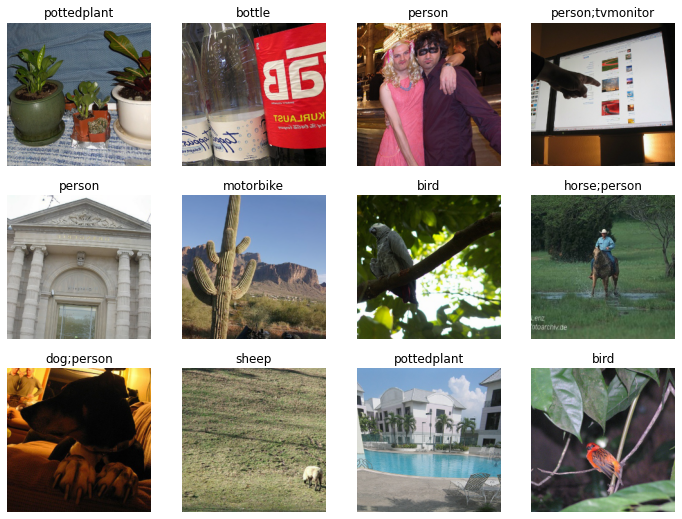

In [0]:
dls.show_batch(max_n=12)

Make the learner the normal way we are used to

However, since we are doing a multi label classification, we cannot use accuracy to tell if the model is correctly labelling every image. We want a way to tell the model that after it has predicted the probabilities for each class, it should select the one with probs above a certain set threshold(0.6 in our case) and then use these selected classes to compare to the actuals. Thank fully fastai has a way of doing this easily. It is done with the `accuracy_multi` metric method which can takes in a default thresholde value of 0.5. this value can be changed

In [0]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.6))

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.04786301031708717)

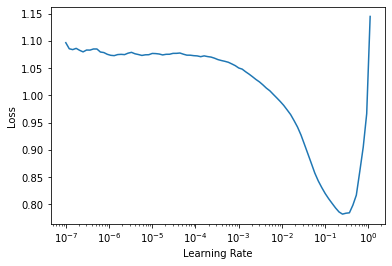

In [0]:
learn.lr_find()

In [0]:
learn.fine_tune(4, 1e-02)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

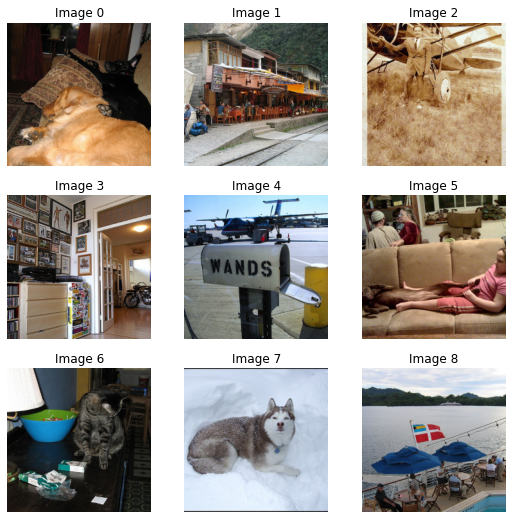

In [0]:
interp.plot_top_losses(9)

As you can see our model is doing preety well. The Images it has misclassified are easily justifiable considering how they look as shown above

In [0]:
idx = 20
dls.valid_ds.items.iloc[[idx]]

fname     labels  is_valid
42  000093.jpg  dog chair      True

In [0]:
image = dls.valid_ds.items.iloc[[idx]]['fname'].values[0]

In [0]:
upload = SimpleNamespace(img=str(path/'train')+os.path.sep+image)

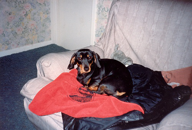

In [0]:
PILImage.create(upload.img).to_thumb(192)

In [0]:
learn.predict(upload.img)

((#2) ['dog','sofa'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False,  True, False, False]),
 tensor([1.4927e-04, 1.5531e-03, 4.2016e-04, 5.1603e-04, 5.1259e-03, 2.2610e-04,
         1.2620e-03, 3.5001e-02, 5.0245e-02, 7.6448e-04, 1.4572e-03, 9.6842e-01,
         5.3282e-04, 1.4891e-03, 8.4883e-02, 8.4568e-03, 6.9384e-05, 6.7182e-01,
         5.9690e-04, 6.2309e-03]))

Pretty neat if you ask me

Midlevel API

In [0]:
os.path.sep

'/'

As you can see, this time we have a `MultiCategory` block because we have multi lables for each class. 

We are using a `get_x` getter this time intead of a `get_item` because all the imagesItems have already been listed out and we really don't care about the suffixes attached to each imageItem

In [0]:
data = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                #  we'll use a column reader to read the columns fo the dataframe
                 get_x=ColReader(cols='fname', pref=str(path/'train')+os.path.sep),
                 splitter = ColSplitter(col='is_valid'),
                 get_y=ColReader(cols='labels', label_delim=' '),
                 item_tfms=Resize(448), 
                 batch_tfms=aug_transforms(size =224))

In [0]:
dls = data.dataloaders(df)

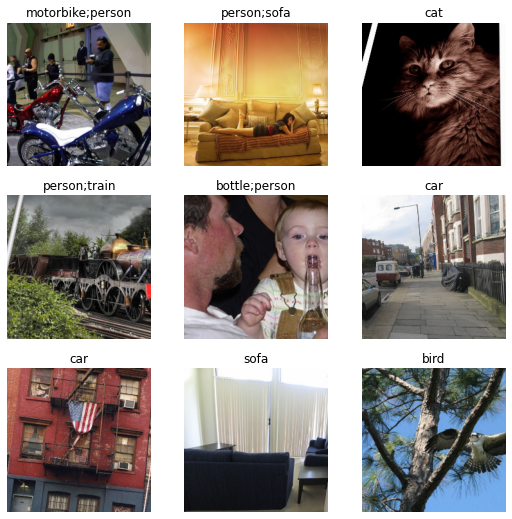

In [0]:
dls.show_batch()

Once again, the training process is same as before

## Segmentation

I'm sure you're tired, so am I. The good news is that we've both learnt a lot from this so congrats to us!!

Now we look at segmentation and as per usual, we'll consider both the modlevel and high level APIs

We'll be making use of the camvid dataset

In [0]:
path = untar_data(URLs.CAMVID_TINY)
path.ls(), len((path/'images').ls())

((#3) [Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/codes.txt')],
 100)

In [0]:
files = get_image_files(path/'images')
len(files)

100

The labels(masks) for the images are in the `labels` folder while the class names are in the `codes.txt` file

In [0]:
codes  = np.loadtxt(path/'codes.txt', dtype='str')
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
(path/'images').ls()

(#100) [Path('/root/.fastai/data/camvid_tiny/images/0016E5_08370.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f02070.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f02370.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_05310.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_06090.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f01830.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_08101.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_00840.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_08141.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f03750.png')...]

In [0]:
(path/'labels').ls()

(#100) [Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08340_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0016E5_07979_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08093_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0006R0_f02550_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08550_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0001TP_007500_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f01950_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0001TP_008160_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08137_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/0001TP_009360_P.png')...]

As we can see, the labels file names are very similar to the image file names which means we can use a function to extract these labels

In [0]:
labeller = lambda x: path/f'labels/{x.stem}_P{x.suffix}'

In [0]:
list(map(labeller, (path/'images').ls()[:2]))

[Path('/root/.fastai/data/camvid_tiny/labels/0016E5_08370_P.png'),
 Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f02070_P.png')]

High level API

since we are using a label to extract the funstions, we use a `from_label_func` but this time we use a `SegmentationDataLoaders` class since we are working with segmentation

In [0]:
dls = SegmentationDataLoaders.from_label_func(path, fnames=files, label_func=labeller, codes=codes, bs=8)

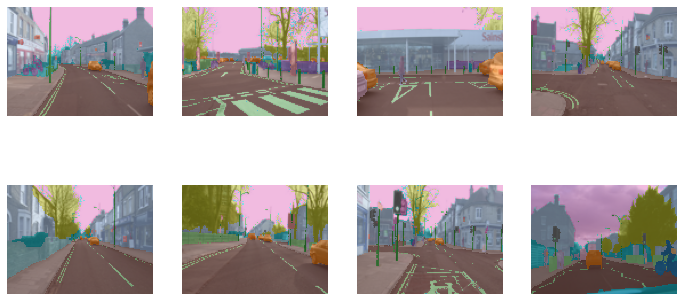

In [0]:
dls.show_batch(max_n=12)

We can create a simple learner object. For segmentation tasks, the best learners are unet learners because of they ability to transfer state from the downsampling/encoder region to the upsampling/decoder region. The encoder for the learner is the resnet34 we are used to

In [0]:
learn = unet_learner(dls, arch=resnet34)

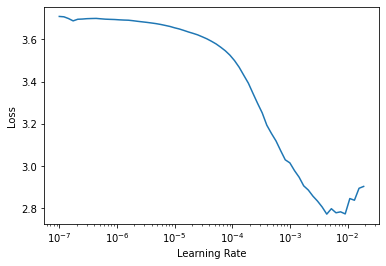

In [0]:
lr = learn.lr_find()

In [0]:
lr

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=0.0003311311302240938)

In [0]:
learn.fine_tune(10, lr[1])

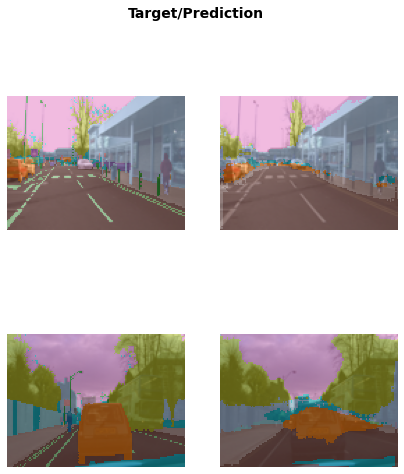

In [0]:
learn.show_results(max_n=6, figsize=(7, 8))

**Confusion**: max_n doesn't show more than 4 images

Using the midlevel API

since we're doing segmentation which is a form of masking the label type will be a MaskBlock

In [0]:
data = DataBlock(blocks=(ImageBlock, MaskBlock), 
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                #  pass in the function we defined to get y
                 get_y=labeller,
                 item_tfms=Resize(224),
                #  I chose the size as (120, 160) because why not
                 batch_tfms=aug_transforms(size=(120, 160)))

Remember this is just the architecture/function. We need to pass data into it's DataLoaders

In [0]:
dls = data.dataloaders(path/'images')

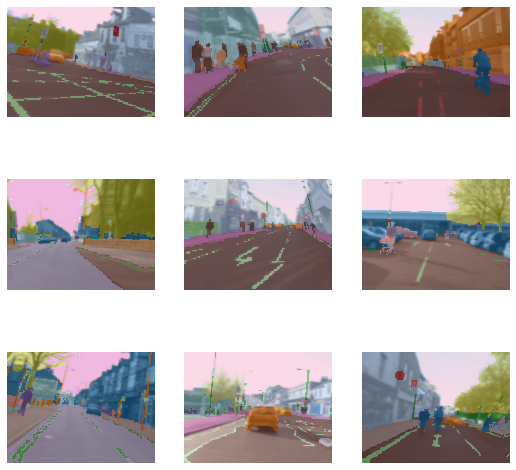

In [0]:
dls.show_batch()

Training follows the same process as previous

## Regression

Most of what we;ve been focused on has been classification. Let's do some regression. We want to predict the position of a point on some pictures

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/08.obj'),Path('/root/.fastai/data/biwi_head_pose/07'),Path('/root/.fastai/data/biwi_head_pose/08'),Path('/root/.fastai/data/biwi_head_pose/07.obj'),Path('/root/.fastai/data/biwi_head_pose/22.obj'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/05'),Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/10.obj')...]

In [0]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00009_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00355_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00357_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00301_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00037_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00246_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00095_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00367_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00036_pose.txt')...]

Using the highlevel API

In [0]:
coords = pickle.load(open(path/'centers.pkl', 'rb'))

I've always disliked this BIWI head pose estimation problem. It just doesn't sit well with me haha

################### Unfinished #######################################

## Images with bounding boxes

The goal here is to predict the locations of bounding boxes over an image. We'll be making use of the ..... you guessed right common objects (COCO) dataset. Fastai makes everything really easy to do

In [0]:
path = untar_data(URLs.COCO_TINY)
path.ls(), len((path/'train').ls())

((#2) [Path('/root/.fastai/data/coco_tiny/train'),Path('/root/.fastai/data/coco_tiny/train.json')],
 200)

Fastai built has a custom method for extracting the images categories and theor bounding boxes out of the .json file. The method is `get_annotations`

In [0]:
img2bbox = get_annotations(path/'train.json')

look at the order

In [0]:
img2bbox[0][0], img2bbox[1][0]

('000000542959.jpg',
 ([[32.52, 86.34, 41.050000000000004, 95.75],
   [98.12, 110.52, 100.07000000000001, 114.59],
   [91.28, 51.62, 95.23, 57.339999999999996],
   [110.48, 110.82, 125.03, 126.03999999999999],
   [96.63, 50.18, 115.3, 63.64],
   [0.69, 111.73, 12.49, 124.79]],
  ['chair', 'vase', 'vase', 'chair', 'chair', 'chair']))

We make a a dictionary out of this

In [0]:
img2bbox = dict(zip(images, bbox_lbl))

such that

In [0]:
img2bbox['000000006190.jpg']

([[16.15, 10.85, 38.31, 21.32], [0.0, 71.0, 128.0, 84.65]],
 ['remote', 'couch'])

let's extract out image items from the `L` object `path`

In [0]:
files = get_image_files(path/'train')
files[:5], len(files)

((#5) [Path('/root/.fastai/data/coco_tiny/train/000000454982.jpg'),Path('/root/.fastai/data/coco_tiny/train/000000258854.jpg'),Path('/root/.fastai/data/coco_tiny/train/000000299489.jpg'),Path('/root/.fastai/data/coco_tiny/train/000000540582.jpg'),Path('/root/.fastai/data/coco_tiny/train/000000216899.jpg')],
 200)

Using the Midlevel API

As we know, each of the bounding boxes has a label so we need 3 blocks as shown below

In [0]:
data = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_x = lambda o: o,
                 splitter = RandomSplitter(valid_pct=0.2, seed=42),
                #  since we kinda have two labels, the bounding box and the bbox 
                #  caption, we ought to have two functions in a list. Always 
                #  remeber that the get_y will be gotten from hte result of get_x
                 get_y = [lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]],
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(),
                #  since we have one image  and two labels, we need to tell the 
                #  datablock that we have only one x(image) so we call n_inp
                 n_inp=1)

In [0]:
dls = data.dataloaders(files)

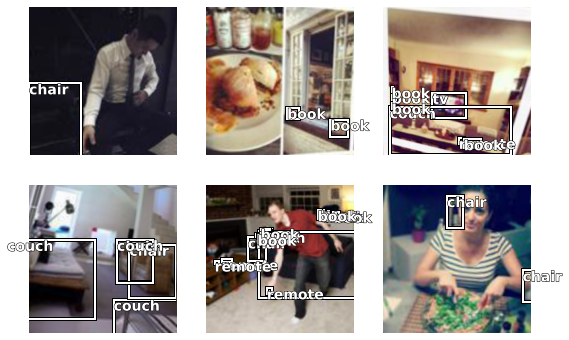

In [0]:
dls.show_batch(max_n=6)

## fin

I hope you enjoyed my preview of the midlevel and highlevel APIs. I'll be introducing the lowlevel API in the next section, stay-tuned

The task we have at hand is to build classifier that will predict the 10 classes in Jeremy's curated IMAGEWOOF dataset. IMAGEWOOF is a subset of the PETS dataset but this time we have only dog breeds (woof woof :)). The classes of dogs represented in this dataset are Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog

In [0]:
path = untar_data(URLs.IMAGEWOOF)
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2/train'),Path('/root/.fastai/data/imagewoof2/val')]

In [0]:
(path/'train').ls(), (path/'train/n02096294').ls()

((#10) [Path('/root/.fastai/data/imagewoof2/train/n02096294'),Path('/root/.fastai/data/imagewoof2/train/n02088364'),Path('/root/.fastai/data/imagewoof2/train/n02115641'),Path('/root/.fastai/data/imagewoof2/train/n02093754'),Path('/root/.fastai/data/imagewoof2/train/n02105641'),Path('/root/.fastai/data/imagewoof2/train/n02087394'),Path('/root/.fastai/data/imagewoof2/train/n02089973'),Path('/root/.fastai/data/imagewoof2/train/n02086240'),Path('/root/.fastai/data/imagewoof2/train/n02111889'),Path('/root/.fastai/data/imagewoof2/train/n02099601')],
 (#943) [Path('/root/.fastai/data/imagewoof2/train/n02096294/n02096294_11544.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02096294/n02096294_1546.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02096294/n02096294_1529.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02096294/n02096294_6829.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02096294/n02096294_12926.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02096294/n02096294_4957.JP

In [0]:
# get the image files from all the folders with recurse
files = get_image_files(path)

As we can see the directory structure is `grandparent_dir->parent_dir->image_item`. This directory structure is also known as the *imagenet directory structure*. Fastai has a class called `GrandParentSplitter` which splits the dataset according to the grandparent_directory names. Our job is to pass in the directory names for the train, valid and optionally test folders and then `__call__()` it on the directory that houses the grandparents_dir

NB: Please note that the result from the grandparentsplitter is not the split file contents(image_paths) but instead the idxs of each image in the `files` `L` object

In [0]:
split_idxs = GrandparentSplitter(train_name='train', valid_name='val')(files)

In [0]:
len(split_idxs)

2

In [0]:
print(split_idxs[0])
print(split_idxs[1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [0]:
len(files), (len(yo[0])+len(yo[1]))

(12954, 12954)

In [0]:
Datasets??

So remember when I introduced a pytorch dataset as something that you can slice into and get the len(), fastai supercharged theirs. In fastai, you can not only slice and find len() in the Datasets (note the name diff), you can also specify the way to split your data into x and y and also you can apply transforms to both the x and y parts of your data individually

The transformations for the x and y are used to preprocess the data we want to convert to a fastai Datasets object. The transforms are put into a list of lists. The lenght of this list of lists can vary from 1-3 where 
- 1 means that we have only one child-list in the parent-list which contains tranforms for the input only, 
- 2 means that we have 2 child-lists in the parent-list that contain transforms for the input and a single lablel and 
- 3 which is 3 child-lists in the parent-list representing n-inputs, n-labels. This is usually for tabular data

NB: The transfroms in each of the child-lists are executed from left to right

In [0]:
# categorize changes the labels to numericals categories
cat = Categorize()
Datasets(['A', 'B', 'C'], tfms=[cat])
# vocab shows all the classes and to get the id for each class, pass it into cat
cat.vocab, cat('B'), cat('B').item()

((#3) ['A','B','C'], TensorCategory(1), 1)

In [0]:
Categorize??

ERROR! Session/line number was not unique in database. History logging moved to new session 63


In [0]:
# this reads as for the images, create them as pillow images, for the labels, 
# get the labels from the parents in the files L and convert them to categories
ds_tfms = [[PILImage.create], [parent_label, Categorize()]]

In [0]:
# n_inp tells the dataset that there is only one tfm child-list for the image. 
# Comes in handy when you have 3 child-lists transforms. The default is 1
dsets = Datasets(files, tfms=ds_tfms, splits=split_idxs, n_inp=1)
dsets

(#12954) [(PILImage mode=RGB size=387x500, TensorCategory(5)),(PILImage mode=RGB size=495x374, TensorCategory(5)),(PILImage mode=RGB size=375x500, TensorCategory(5)),(PILImage mode=RGB size=500x375, TensorCategory(5)),(PILImage mode=RGB size=360x500, TensorCategory(5)),(PILImage mode=RGB size=500x375, TensorCategory(5)),(PILImage mode=RGB size=386x500, TensorCategory(5)),(PILImage mode=RGB size=500x357, TensorCategory(5)),(PILImage mode=RGB size=700x933, TensorCategory(5)),(PILImage mode=RGB size=500x375, TensorCategory(5))...]

As we can see above, the images are still pillow images and not tensors so we need to change them to tensors using an item_tfms also, the images are of different sizes so we need to use an resize them using the same item_tfms(CPU) then we can load them up into batches and choose whatever batch transforms we want on each batch(GPU)

In [0]:
t = ToTensor()
print(type(PILImage.create(files[0])))  # it is a PILImage
type(t(PILImage.create(files[0])))  # It is now a TensorImage

<class 'fastai2.vision.core.PILImage'>


fastai2.torch_core.TensorImage

In [0]:
item_tfms = [ToTensor(), Resize(128)]

In [0]:
FlipItem??

FlipItem(): Literally flips all the images horizontally in each batch with a probability of 0.5

RandomResizedCrop(): Picks out a random scaled crop(by default the scale is 0.8 the original size) of our image and then resizes only the selected crop. The higher the scale, the smaller the crop

IntToFloatTensor(): It normalizes our 255 pixels range valued image matrix to fall between 0 and 1 by dividing it by 255 then it converts the quotient to a float tensor

Normalize.to_stats(*imagenet_stats): Normalizes the images to have the same mean and standard deviation as that which the images in imagenet were trained on

In [0]:
img = PILImage.create(files[0])

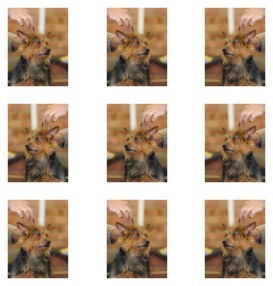

In [0]:
flip = FlipItem(1.)
_,axs = plt.subplots(3,3,figsize=(5,5))
for ax in axs.flatten():
    flipped = flip(img, int(random.random()*1.5))
    show_image(flipped, ctx=ax);

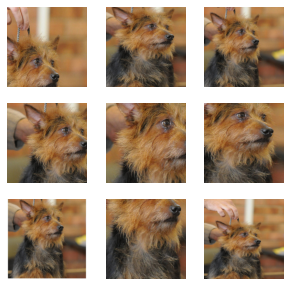

In [0]:
crop = RandomResizedCrop(256)
_,axs = plt.subplots(3,3,figsize=(5,5))
for ax in axs.flatten():
    cropped = crop(img)
    show_image(cropped, ctx=ax);

In [0]:
i2fT = IntToFloatTensor(div=255.0)
ten = TensorImage(tensor([255, 2, 5]))
i2fT(ten)

TensorImage([1.0000, 0.0078, 0.0196])

In [0]:
#Remember that these are executed from left too right
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35), IntToFloatTensor(div=255.), Normalize.from_stats(*imagenet_stats)]

We can now build a Dataloaders object using the Datsets

In [0]:
dls = dsets.dataloaders(bs=32, after_item=item_tfms, after_batch=batch_tfms)

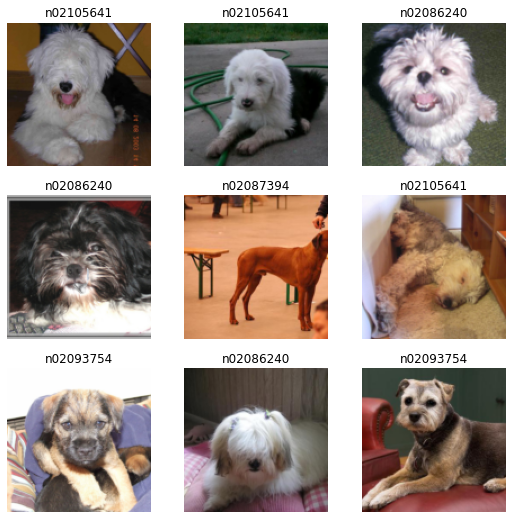

In [0]:
dls.show_batch()